# W207 - Final Project - Shelter Animal Outcomes Kaggle Competition
## Section 2 - Mary Lewis, Darren Lin, Sho Ohata

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.grid_search import GridSearchCV

%matplotlib inline
sns.set(context='poster', style='white', font='Ubuntu')

all_train = pd.read_csv('data/train.csv')
##A cell has an issue so re-coding to Unknown
all_train['SexuponOutcome'][all_train['SexuponOutcome'].isnull()] = 'Unknown'
test = pd.read_csv('data/test.csv')

Just to get an idea of what the dataset looks like.

In [10]:
all_train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


### This section of the code does all of the feature engineering and pre-processing steps.  

##### Various exploratory plots and analysis will be shown after this section to show why we decided to go through these steps.

##### First the breed feature is cleaned up, simplified  and dummy variables are created for select breeds that are known to be good indicators. The second code chunk completes the other various pre-processing steps that converts the other features so it can be pushed through sklearn algorithms.

In [12]:
breed_list = [u'rottweiler', u'lhasaapso', u'chihuahua', u'weimaraner', u'shihtzu', u'chinesesharpei', u'known', 
            u'alaskanmalamute', u'entlebucher', u'vizsla', u'italiangreyhound', u'redbonehound', u'plotthound', 
            u'chowchow', u'irishsetter', u'bassethound', u'bostonterrier', u'englishshepherd', u'stbernard', 
            u'pbgv', u'bloodhound', u'staffordshire', u'englishspringerspaniel', u'pitbull', u'husky', 
            u'snowshoe', u'domesticmediumhair', u'mix', u'mainecoon', u'turkishvan', u'siamese', u'havanabrown', 
            u'domesticlonghair', u'shorthair', u'russianblue', u'cornishrex', u'domesticshorthair', u'exoticshorthair']

def cleanBreed(all_train):
    all_train['Breed'] = all_train['Breed'].str.replace('Black/Tan', 'BlackTan')
    all_train['Breed'] = all_train['Breed'].str.replace('/Unknown', ' Unknown')
    all_train['Breed'] = all_train['Breed'].str.replace('St. Bernard Rough Coat', 'StBernard')
    all_train['Breed'] = all_train['Breed'].str.replace('St. Bernard Smooth Coat', 'StBernard')
    all_train['Breed'] = all_train['Breed'].str.replace('German Shorthair Pointer', 'Pointer')
    all_train['Breed'] = all_train['Breed'].str.replace('German Wirehaired Pointer', 'Pointer')
    all_train['Breed'] = all_train['Breed'].str.replace('Dachshund Longhair', 'Dachshund')
    all_train['Breed'] = all_train['Breed'].str.replace('Dachshund Wirehair', 'Dachshund')
    all_train['Breed'] = all_train['Breed'].str.replace('English Pointer', 'Pointer')
    all_train['Breed'] = all_train['Breed'].str.replace('Chihuahua Shorthair', 'Chihuahua')
    all_train['Breed'] = all_train['Breed'].str.replace('Chihuahua Longhair', 'Chihuahua')
    all_train['Breed'] = all_train['Breed'].str.replace('Alaskan Husky', 'Husky')
    all_train['Breed'] = all_train['Breed'].str.replace('Siberian Husky', 'Husky')
    
    all_train['Breed'] = all_train['Breed'].str.replace(' ', '')
    all_train['Breed'] = all_train['Breed'].str.replace('/', ' known ')
    all_train['Breed'] = all_train['Breed'].str.replace('Unknown', '')
    all_train['Breed'] = all_train['Breed'].str.replace('Australian', '')
    all_train['Breed'] = all_train['Breed'].str.replace('American', '')
    all_train['Breed'] = all_train['Breed'].str.replace('German', '')
    all_train['Breed'] = all_train['Breed'].str.replace('YorkshireTerrier', ' Yorkshire ')
    all_train['Breed'] = [x.lower() for x in all_train['Breed']]

    for a in range(len(breed_list)):
        all_train[breed_list[a]] = [np.array([breed_list[a] in x]).astype(int) for x in all_train['Breed']] 
    
    return(all_train)

all_train = cleanBreed(all_train)
test = cleanBreed(test)

In [13]:
##Dictionary to map Pandas date-time output for calendar dummy variables
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
dayOfWeek_alt={0:'Monday', 1:'TuesFri', 2:'TuesFri', 3:'TuesFri', 4:'TuesFri', 5:'SatSun', 6:'SatSun'}
MonthName={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep',10:'Oct',11:'Nov',12:'Dec'} 
MonthName_alt={1:'JanFeb', 2:'JanFeb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul',
               8:'Aug', 9:'SepNov',10:'SepNov',11:'SepNov',12:'Dec'}
timeOfDay = {5: 'Morning', 6: 'Morning', 7: 'Morning', 8: 'Morning', 9: 'Morning', 10: 'Morning', 11: 'Afternoon',
        12: 'Afternoon', 13: 'Afternoon', 14: 'Afternoon', 15: 'Afternoon', 16: 'Night', 17: 'Night', 18: 'Night',
        19: 'Night', 20: 'Night', 21: 'Night', 22: 'Night', 23: 'Night', 0: 'Midnight',}

##Determine significant datetime (top 10 most frequent dates) in the test data
test['DateTime'] = pd.to_datetime(test['DateTime'])
significant_dates = list(test.groupby(test.DateTime.dt.normalize()).count()['DateTime']\
                     .sort_values(ascending=False)[:10].index)

##This will be used as column names for the dataframe
date_cols = [str(x)[:10] for x in significant_dates]

##Returns dummy variable if the breed name contains the word Mix
def mixedBreed(s):
    if 'mix' in s.lower():
        return 1
    else:
        return 0

##Function that removes the word mix and removes spaces. This is not used for the model but for plotting
def shortenBreed(s):
    s = s.lower()
    s = re.sub(' mix', '', s)
    s = re.sub('\\/.*', '', s)
    return s

##Function that maps various age group into different categories. These different categories will be converted to
##dummy variables later on.
##For example, any age group larger than 3 years will be coded with the original age.
def RecodeAges(s):
    more3_yr = ['13year','14year','15year','16year','17year','18year','19year','20year','3year','4year',
                '5year','6year','7year','8year','9year','10year','11year','12year']
    lessone_yr = ['3month','4month','5month','6month','7month','8month','9month','10month','11month','0year']
    lessone_wk = ['1day','2day','3day','4day','5day','6day']
    lessone_mo = ['1week','1week','2week','3week','4week']
    oneortwo_mo = ['1month','5week','2month']
    oneortwo_yr = ['1year','2year']
    
    ##Remove the letter s from end of age group string, otherwise assign it as unknown
    if isinstance(s, str):
        age = re.sub('[s, ]','', s)
    else:
        return 'UnknownAge'
    
    ##Return age group
    if age in more3_yr:
        return age
    elif age in lessone_yr:
        return '< 1yr'
    elif age in lessone_mo:
        return '< 1mo'
    elif age in oneortwo_mo:
        return '1 - 2 mos'
    elif age in oneortwo_yr:
        return '1 - 2 yrs'
    else:
        return '< 1wk'

##Function that processes selected features to be concatenated prior to pushing it through CountVectorizers
##Functions provided above converts either into dummy variables or converts into string to be processed
##by count vectorizer
def process_data(df):
    ##Name column will be turned to either the animal having a name or unnamed
    df.ix[pd.isnull(df['Name']), 'Named'] = 'Unnamed'
    df.ix[pd.isnull(df['Named']), 'Named'] = 'Named'
    
    ##Convert to datetime to be processed by functions above
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['weekday'] = df['DateTime'].dt.dayofweek.map(dayOfWeek_alt)
    df['month'] = df['DateTime'].dt.month.map(MonthName_alt)
    df['hour'] = df['DateTime'].dt.hour
    df['minute'] = df['DateTime'].dt.minute
    df['minutezero'] = (df['minute'] == 0).astype(int)
    
    df['ageGroups'] = df['AgeuponOutcome'].map(RecodeAges)
    
    df['mix'] = df['Breed'].map(mixedBreed)
    df['shortBreed'] = df['Breed'].map(shortenBreed)

    for dt in significant_dates:
        df[str(dt)[:10]] = map(lambda x: x.normalize() == dt, df.DateTime)
        df[str(dt)[:10]] = df[str(dt)[:10]].astype(int)
    
    ##Concatenate the various features
    df['corp'] = df.apply(lambda x: ' '.join((x.Color, x.SexuponOutcome, x.Named, 
                                                       x.weekday, x.month)), axis=1)
    return df

all_train = process_data(all_train)
##Use CountVectorizer to convert the concatenated column into a numpy array with the various features
cv = CountVectorizer(min_df=0.05)
train_corpus = cv.fit_transform(all_train.corp)

##Function to convert sparse matrix output from count vectorizer to dense matrix.
##Then it will add other features like animal type, dummy variables from the above dataframe
##and add the breed features that was done all the way at the top
def add_other_features(corpus, df, training=True):
    ##Convert sparse matrix to dense so it can be concatenated
    dense_corpus = pd.DataFrame(corpus.toarray(), columns = cv.get_feature_names())
    
    ##Concatenate other dummy variables
    add = pd.concat([(df.AnimalType == 'Dog').astype(int), 
                     df.minutezero,
                     df[date_cols],
                     pd.get_dummies(df.hour),
                    pd.get_dummies(df.ageGroups),
                    df.ix[:,breed_list]], axis=1)
    
    if training:
        add = pd.concat([add, df.OutcomeType], axis=1)
    return pd.concat([dense_corpus, add], axis=1)

new_corp = add_other_features(train_corpus, all_train)

##Finally split the dataframes into dev and train data to assess model performances
split = new_corp.shape[0] // 20
dev = new_corp.iloc[:split,:-1]
train = new_corp.iloc[split:,:-1]

dev_labels = new_corp.iloc[:split,-1]
train_labels = new_corp.iloc[split:,-1]

##Process the test dataset also.
test = process_data(test)

#### Before pushing it through a machine learning algorithm, this section will cover some of the initial exploratory work we performed to identify the key features of the dataset.

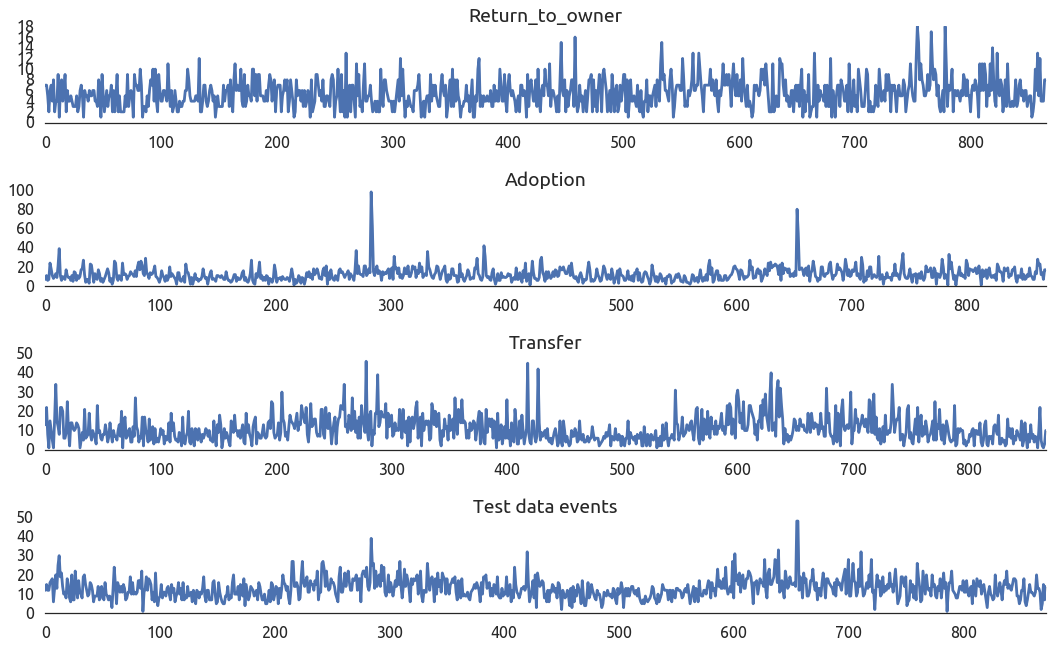

In [4]:
##Create time series graph for the various outcomes as well as the test dataset to see if there are any trends in there
##that should be captured in the training set.
plt.figure(figsize=(15,9))
for i, outcome in enumerate(['Return_to_owner','Adoption','Transfer']):
    d = all_train[all_train.OutcomeType == outcome]
    plt.subplot(4,1,i+1)
    sns.tsplot(d.groupby([d.DateTime.dt.normalize()]).count()['AnimalID'])
    plt.title(outcome)
    plt.tight_layout()
    sns.despine(left=True)
    
plt.subplot(4,1,4)
sns.tsplot(test.groupby([test.DateTime.dt.normalize()]).count()['DateTime'])
plt.title('Test data events')
sns.despine(left=True)

As can be seen by the time series graph there are significant times where spikes in outcomes occur.

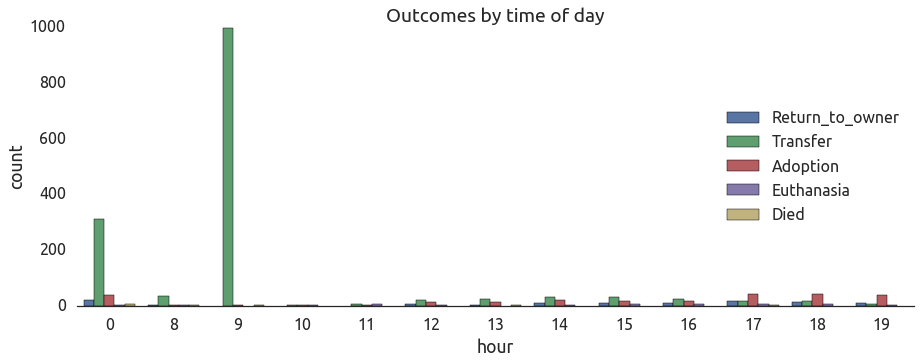

In [5]:
##Plot bar chart of outcomes by hour time stamp
plt.figure(figsize=(15,5))
plt.title('Outcomes by time of day')

sns.countplot(x='hour', hue='OutcomeType', data=all_train[all_train['minutezero'] == 1])
plt.legend(loc='right')

sns.despine(left=True)

Now that we drilled down further it looks like certain hour time stamps will be a good indicator of transfer.

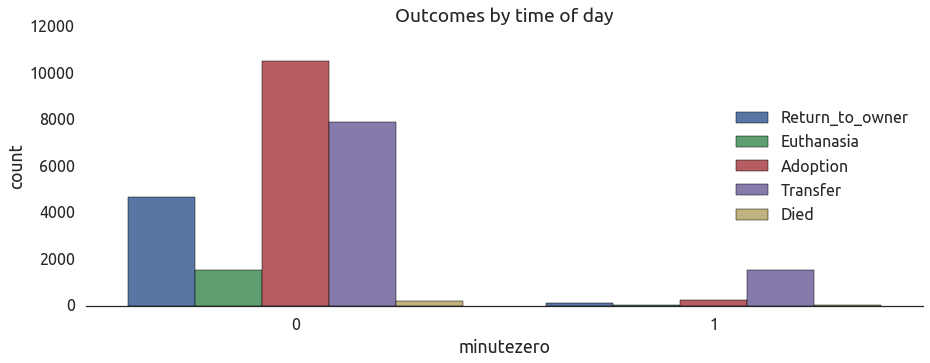

In [6]:
##Plot bar chart of outcomes by minute timestamp. 0 is indicator of minute mark being zero, 1 otherwise.
plt.figure(figsize=(15,5))
plt.title('Outcomes by time of day')

sns.countplot(x='minutezero', hue='OutcomeType', data=all_train)
plt.legend(loc='right')


sns.despine(left=True)

Once again there are significant differences when the timestamps minute marker is zero.

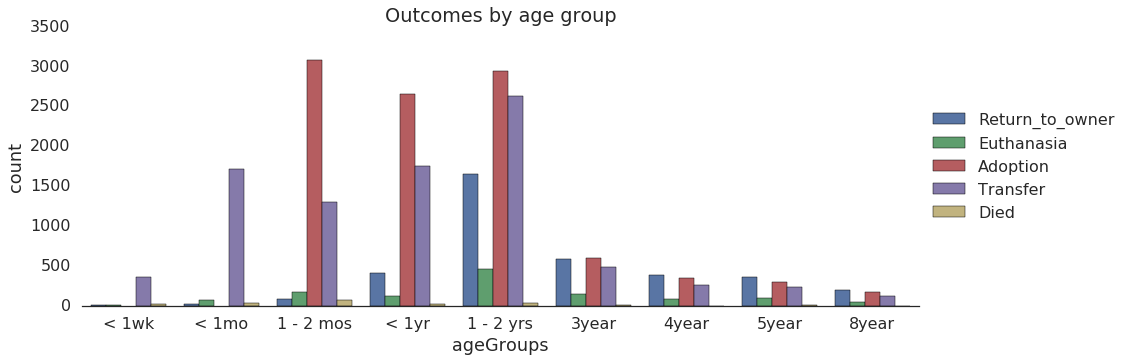

In [17]:
##Plot outcomes by age group
plt.figure(figsize=(15,5))
plt.title('Outcomes by age group')

sns.countplot(x='ageGroups', hue='OutcomeType', data=all_train, 
              order=['< 1wk','< 1mo','1 - 2 mos', '< 1yr','1 - 2 yrs','3year','4year', '5year', '8year'])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.despine(left=True)

As can be seen outcome proportions differ depending on which age group they are in. Adoption rates seem to be much higher once they are between 1 month and higher. Return to owner rate seems to increase the older the animal. 

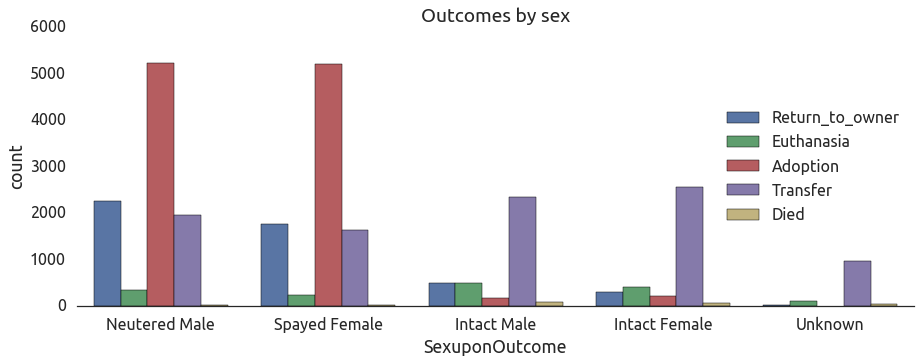

In [8]:
##Plot outcomes by sex
plt.figure(figsize=(15,5))
plt.title('Outcomes by sex')

sns.countplot(x='SexuponOutcome', hue='OutcomeType', data=all_train)
plt.legend(loc='right')

sns.despine(left=True)

Unsurprisingly neutered/spayed animals are adopted at a much larger rate. Intact animals seem to get transferred, presumably to a facility to get them neutered/spayed.

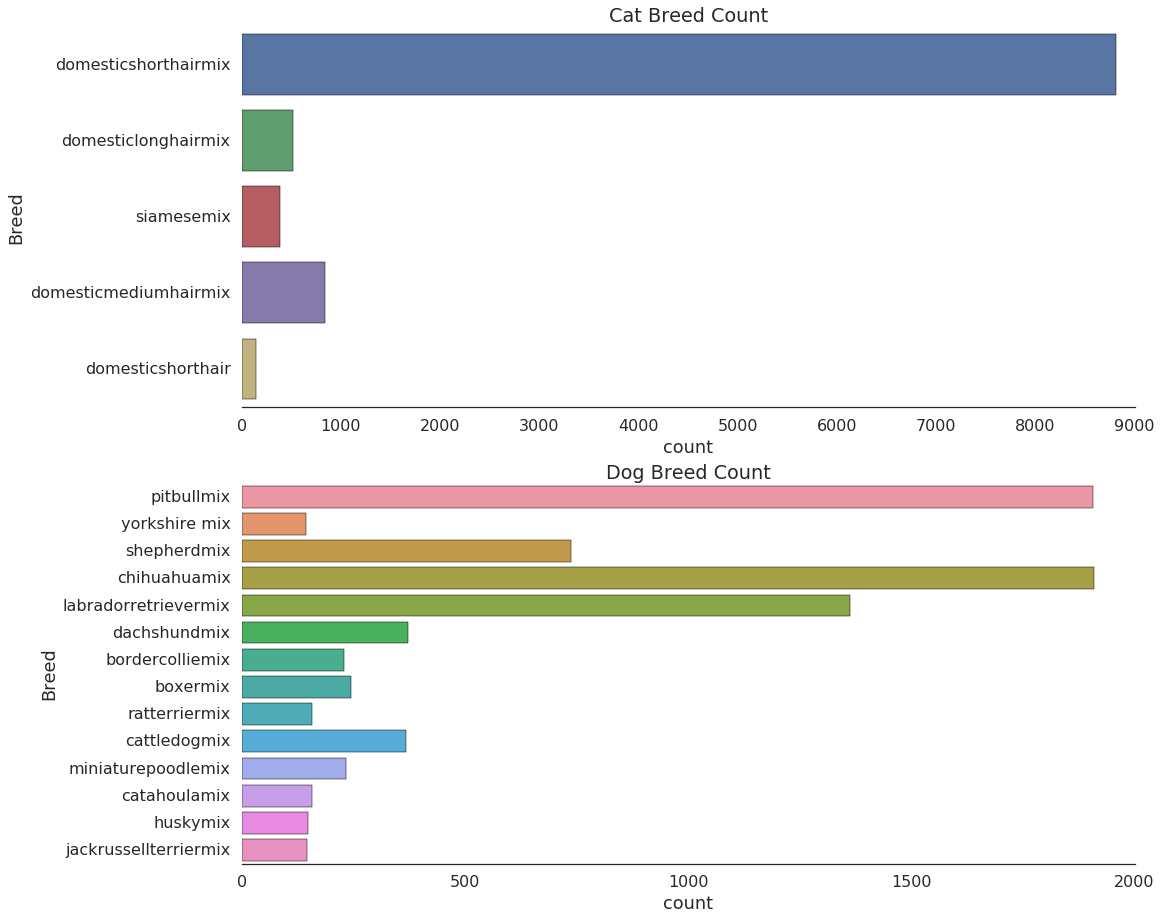

In [18]:
##Exploring some of the breed features. Dogs have a much larger variety so cats and dogs are separated.
all_train_cat = all_train[all_train['AnimalType']=='Cat']
all_train_dog = all_train[all_train['AnimalType']=='Dog']

##Taking only the popular breed type for plotting
pop_cat = list(all_train_cat['Breed'].value_counts()[all_train_cat['Breed'].value_counts() > 100].index)
plot_cat = all_train_cat[all_train_cat['Breed'].isin(pop_cat)]

pop_dog = list(all_train_dog['Breed'].value_counts()[all_train_dog['Breed'].value_counts() > 140].index)
plot_dog = all_train_dog[all_train_dog['Breed'].isin(pop_dog)]

plt.figure(figsize=(16,15))

plt.subplot(2,1,1)
sns.countplot(y='Breed', data=plot_cat)
sns.plt.title('Cat Breed Count')

plt.subplot(2,1,2)
sns.countplot(y='Breed', data=plot_dog)
plt.title('Dog Breed Count')

sns.despine(left=True)

As can be seen cats predominant breed type is domestic short hair mix. On the other hand for dogs pitbull mix and chihuahua mix are most prevalent. However, dogs have a much larger variety of breeds identified.

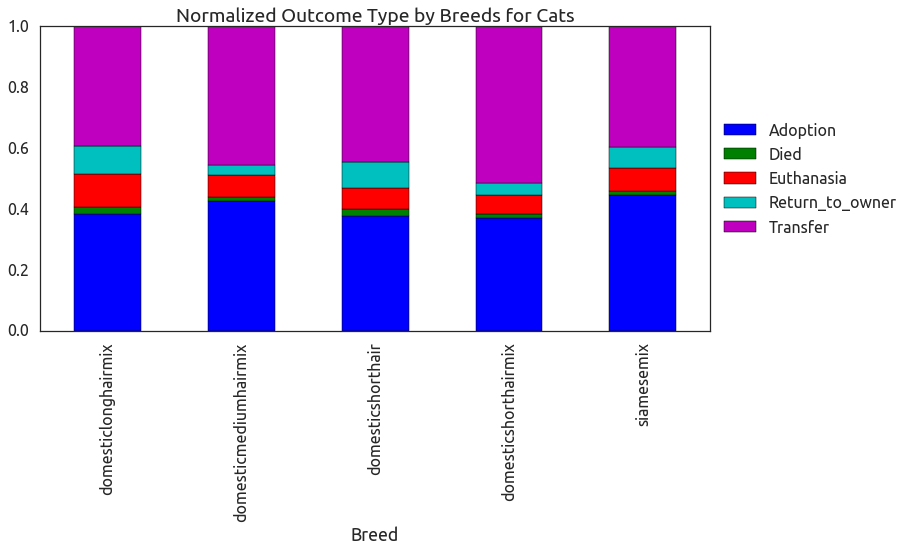

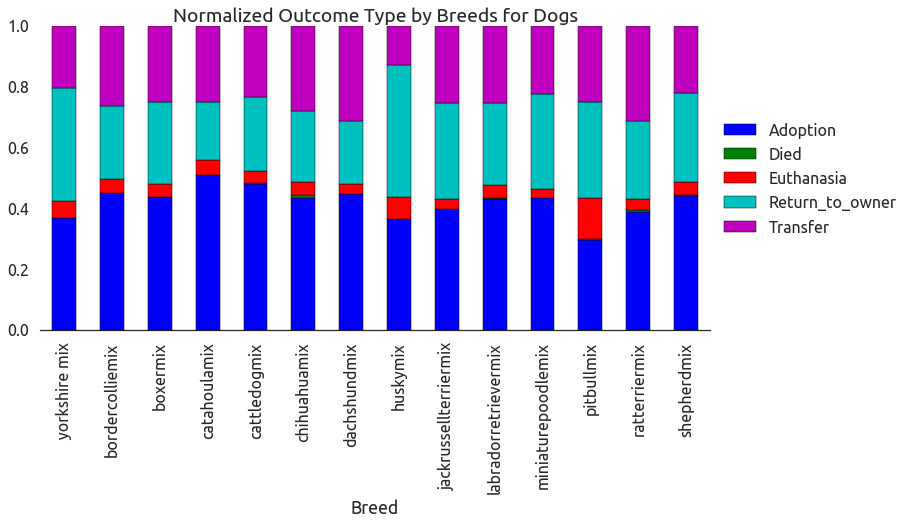

In [10]:
##Plot normalized stacked barchart to identify significant differences in outcomes by breed

##Group by breed and get number of counts. Then divide the outcome so normalized value is obtained
cat_outcome = plot_cat.groupby(['Breed','OutcomeType']).size().unstack()
cat_outcome_normalized = cat_outcome.div(plot_cat.groupby(['Breed']).size(),axis='rows')

dog_outcome = plot_dog.groupby(['Breed','OutcomeType']).size().unstack()
dog_outcome_normalized = dog_outcome.div(plot_dog.groupby(['Breed']).size(),axis='rows')

fig=plt.figure(figsize=(12,12))
ax = fig.add_subplot(2,1,1)
ax = cat_outcome_normalized.plot(kind='bar',stacked=True,ax=ax, title="Normalized Outcome Type by Breeds for Cats")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig=plt.figure(figsize=(12,12))
ax = fig.add_subplot(2,1,2)
ax = dog_outcome_normalized.plot(kind='bar',stacked=True,ax=ax, title="Normalized Outcome Type by Breeds for Dogs")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine(left=True)

Certain breeds have outcome rates that are significantly differnt than others. For example pitbull and husky mix stands out as significant outliers compared to the rest of the group. Among cats the differences are subtler but there are differences.

#### This section will look at the various Machine Learning algorithms we tested our dataset with. We tried random forest, stochastic gradient descent as well as logistic regression.

RF Log Loss: 0.994
RF Accuracy: 0.651


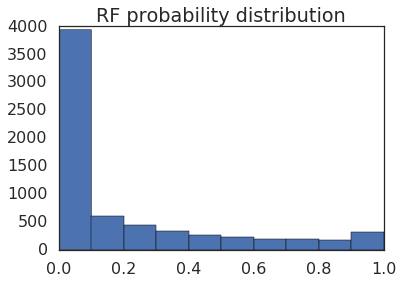

In [20]:
##Random Forest 
clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, criterion='entropy')
clf.fit(train, train_labels)
preds = clf.predict_proba(dev)
print 'RF Log Loss: {:.3f}'.format(log_loss(dev_labels, preds, eps=0.1))
print 'RF Accuracy: {:.3f}'.format(clf.score(dev, dev_labels))

plt.subplot(2,2,4)
plt.hist(preds.ravel(), range=[0,1])
plt.title('RF probability distribution')

The results look good but the log loss seems high.

SGD Log Loss: 0.967
SGD Accuracy: 0.656


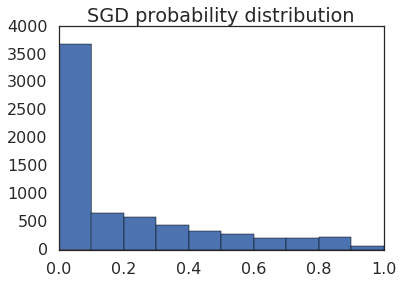

In [23]:
##SGD 
clf = SGDClassifier(loss = 'log', penalty = 'l2', fit_intercept=False, average=10000, alpha = 0.001, eta0=0.00001, n_iter= 20)
clf.fit(train, train_labels)

preds = clf.predict_proba(dev)
print 'SGD Log Loss: {:.3f}'.format(log_loss(dev_labels, preds, eps=0.1))
print 'SGD Accuracy: {:.3f}'.format(clf.score(dev, dev_labels))

plt.subplot(2,2,4)
plt.hist(preds.ravel(), range=[0,1])
plt.title('SGD probability distribution')

SGD performance looks similar to random forest.

Logistic Regression Log Loss: 0.810
Logistic Regression Accuracy: 0.662


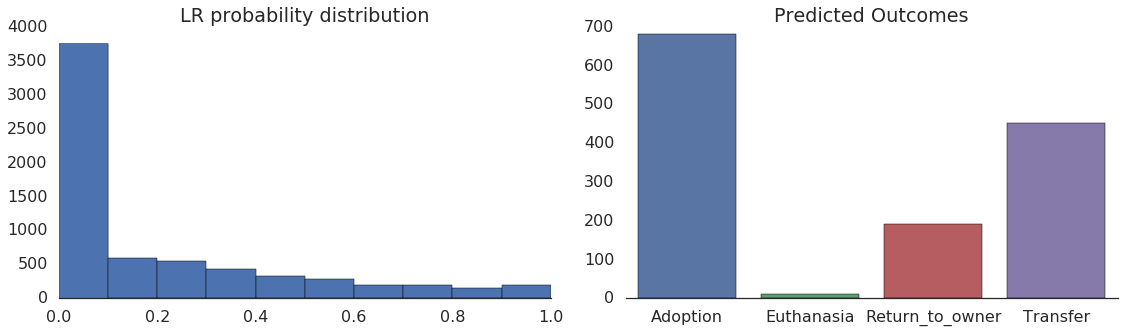

In [35]:
##Logistic regression
clf = LogisticRegression(penalty='l1', C=1)
clf.fit(train, train_labels)
probs = clf.predict_proba(dev)
preds = clf.predict(dev)
print 'Logistic Regression Log Loss: {:.3f}'.format(log_loss(dev_labels, probs))
print 'Logistic Regression Accuracy: {:.3f}'.format(clf.score(dev, dev_labels))

plt.figure(figsize=(16,5)) 
plt.subplot(1,2,1)
plt.hist(probs.ravel(), range=[0,1])
plt.title('LR probability distribution')

plt.subplot(1,2,2)
sns.barplot(np.unique(preds, return_counts=True)[0], np.unique(preds, return_counts=True)[1])
plt.title('Predicted Outcomes')

plt.tight_layout()
sns.despine(left=True)

In terms of log loss, logistic regression seems to be performing the best. Some additional tests and hyper parameter optimization on logistic regression will be performed below.

In [25]:
##Sensitivity analiysis by filtering low performing coefficients and see how that impacts log loss.
for sensitivity in [0, 0.001, 0.01, 0.1, 0.5, 1]:
    reduced_train = train.iloc[:,np.where(abs(np.sum(clf.coef_, axis=0)) > sensitivity)[0]]
    reduced_dev = dev.iloc[:,np.where(abs(np.sum(clf.coef_, axis=0)) > sensitivity)[0]]

    clf_new = LogisticRegression(penalty='l2', C=1)
    clf_new.fit(reduced_train, train_labels)
    probs = clf_new.predict_proba(reduced_dev)
    preds = clf_new.predict(reduced_dev)
    print 'LR loss with sensitivity {:.2f}: {:.3f} with {:d} columns'.format(sensitivity, log_loss(dev_labels, probs),
                                                                            len(reduced_train.columns))

LR loss with sensitivity 0.00: 0.811 with 120 columns
LR loss with sensitivity 0.00: 0.811 with 120 columns
LR loss with sensitivity 0.01: 0.811 with 105 columns
LR loss with sensitivity 0.10: 0.813 with 68 columns
LR loss with sensitivity 0.50: 0.836 with 35 columns
LR loss with sensitivity 1.00: 0.873 with 16 columns


As can be seen, selection of optimal weights seems unfruitful for the model so this was not included in the model.

In [32]:
##Use GridSearchCV to determine best C
Cs = {'C': [.1, .3, .5, 1, 5, 10]}

logreg = LogisticRegression(penalty='l1')
clf = GridSearchCV(logreg, Cs)
clf.fit(train, train_labels)
best_c = clf.best_params_['C']
print 'Best Parameter C:', best_c

Best Parameter C: 5


While GridSearchCV produced a different C parameter we found that using C = 1 was optimal.

#### Assessments of results with the dev data

[[457   0   1  37  46]
 [  0   0   0   0   5]
 [ 21   0   7  17  35]
 [117   0   1  92  38]
 [ 86   0   2  44 330]]


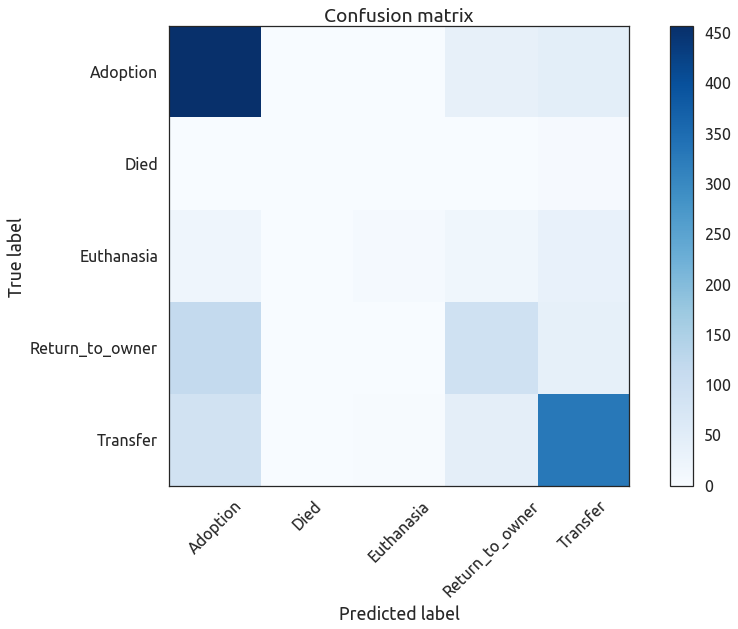

In [12]:
##Output confusion matrix
cm = confusion_matrix(dev_labels, preds, labels=clf.classes_)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=clf.classes_):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print cm

As can be seen by the resulting confusion matrix, the model is able to correctly capture adoption and transfer outcome types. The model struggles with correctly predicting died, euthanasia and return to owner. 

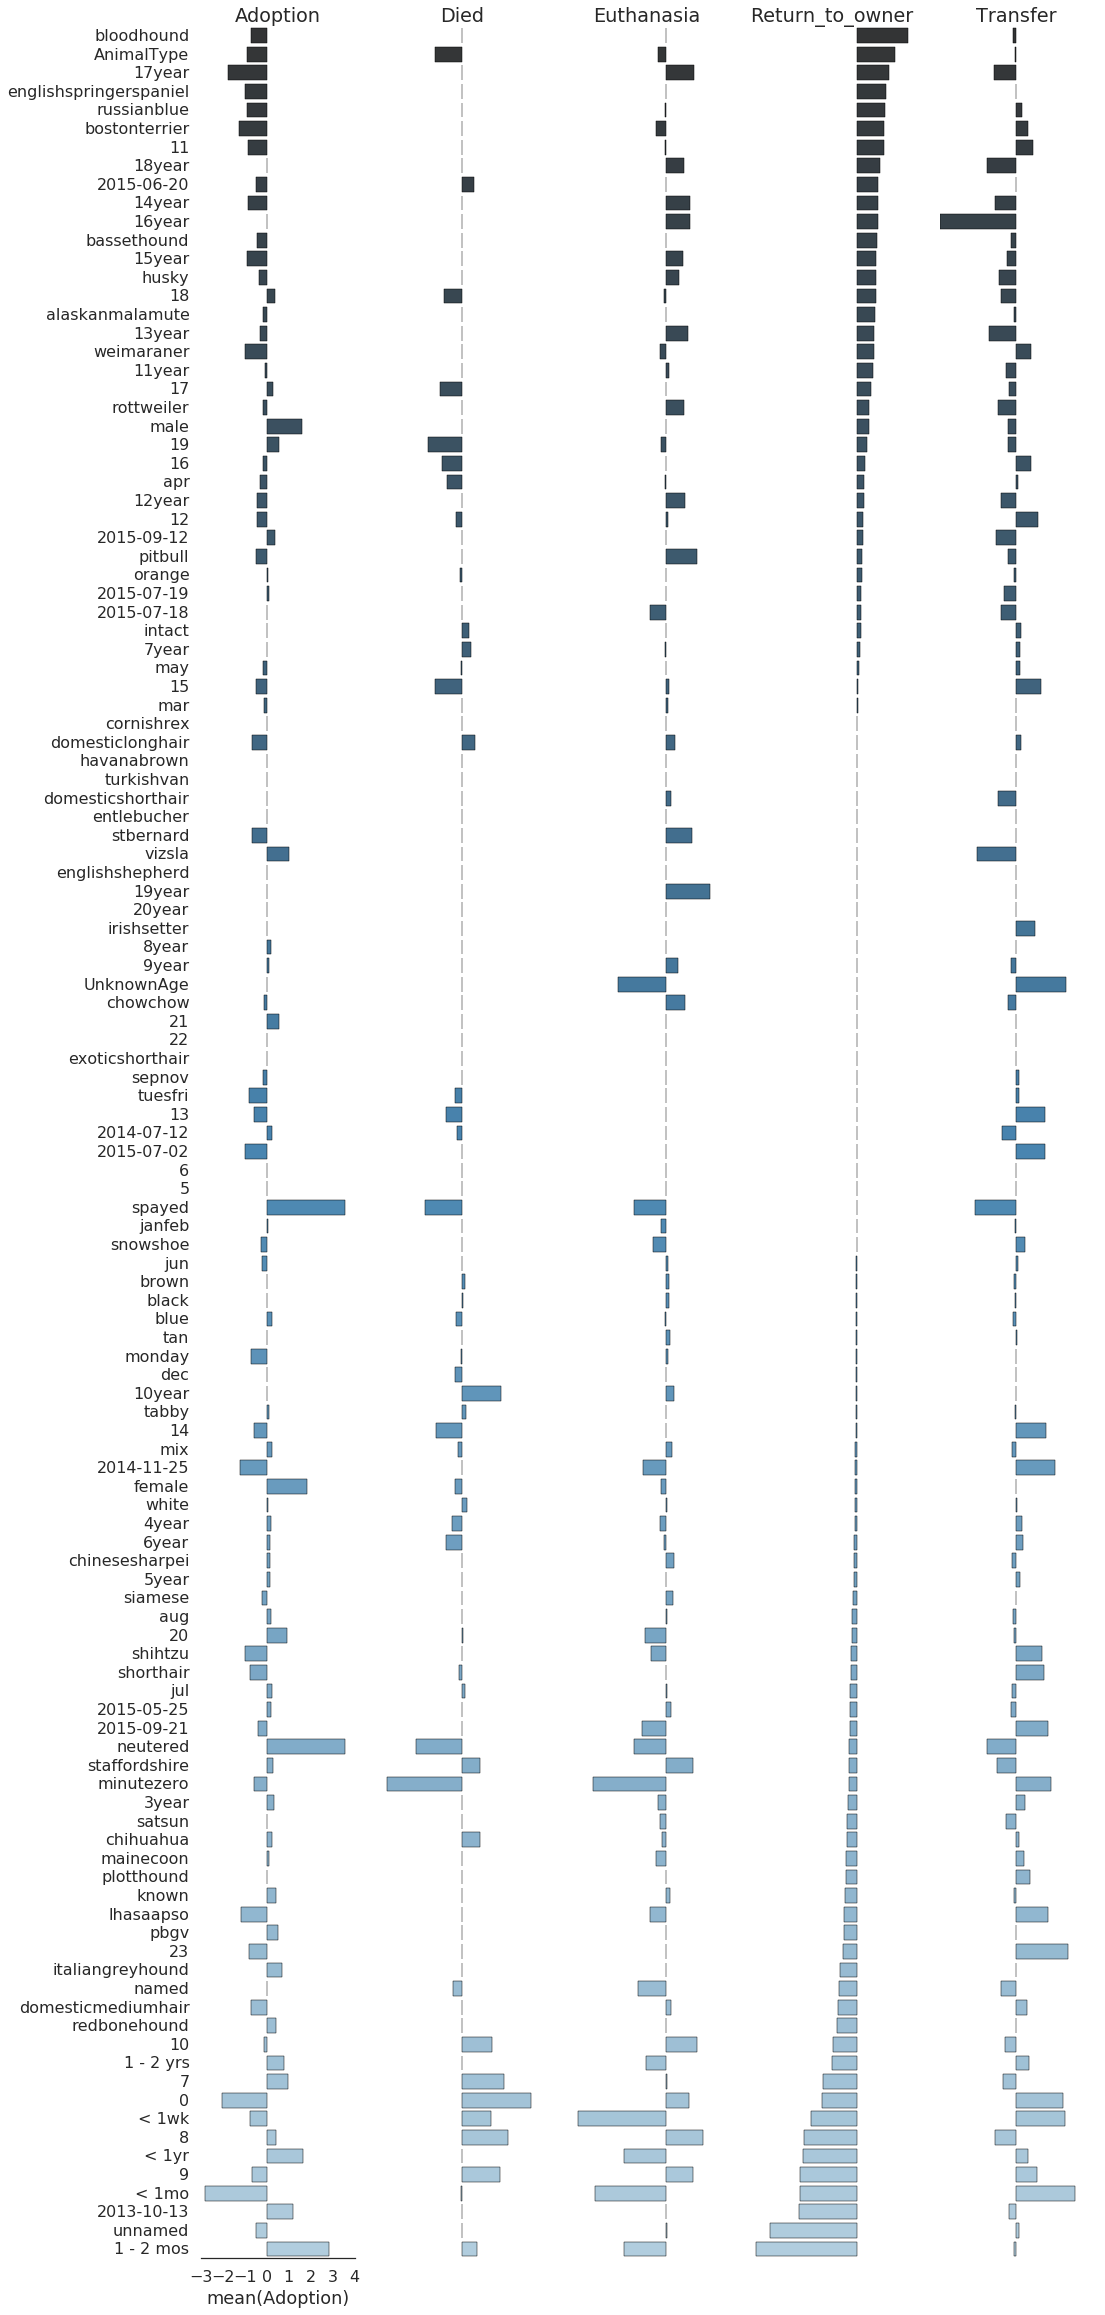

In [37]:
##Extract coefficients from the features for plotting
feat_import = pd.DataFrame(clf.coef_, 
                           columns=train.columns, 
                           index=clf.classes_).T.sort_values('Return_to_owner', ascending=False)

plt.figure(figsize=(16,40)) 

for i, j in enumerate(feat_import.columns):
    plt.subplot(1,5,i + 1)
    sns.barplot(x=feat_import.loc[:,j], y=feat_import.index, orient="h", palette='Blues_d')
    plt.title(j)
    if i > 0:
        plt.axis('off')
        
sns.despine(left=True)

Many of the features used have significant coefficients.

In [36]:
##This block is for submitting to Kaggle without splitting up the data to cats and dogs and creating separate models.
clf.fit(new_corp.iloc[:,:-1], new_corp.iloc[:,-1])

test = process_data(test)

test_corpus = cv.transform(test.corp)
new_test = add_other_features(test_corpus, test, training=False)

preds = clf.predict_proba(new_test)

for i, outcome in enumerate(clf.classes_):
    test[outcome] = preds[:,i]
    
test['prediction'] = clf.predict(new_test)

##submission = test[['ID','Adoption','Died','Euthanasia','Return_to_owner','Transfer']]
##submission.to_csv('submission.csv', index=False)

#### Finally, submit output for kaggle.

In [8]:
##Split up dogs and cats for two different LR models.
dogs = new_corp[new_corp.AnimalType == 1]
cats = new_corp[new_corp.AnimalType == 0]
dogs_test = new_test[new_test.AnimalType == 1]
cats_test = new_test[new_test.AnimalType == 0]

clf.fit(dogs.iloc[:,:-1], dogs.iloc[:,-1])
preds = clf.predict_proba(dogs_test)
dogs_test['ID'] = test[test.AnimalType == 'Dog']['ID']
for i, outcome in enumerate(clf.classes_):
    dogs_test[outcome] = preds[:,i]
    
clf.fit(cats.iloc[:,:-1], cats.iloc[:,-1])
preds = clf.predict_proba(cats_test)
cats_test['ID'] = test[test.AnimalType == 'Cat']['ID']
for i, outcome in enumerate(clf.classes_):
    cats_test[outcome] = preds[:,i]
    
submission = pd.concat([dogs_test[['ID','Adoption','Died','Euthanasia','Return_to_owner','Transfer']],
                       cats_test[['ID','Adoption','Died','Euthanasia','Return_to_owner','Transfer']]])
submission.to_csv('submission.csv', index=False)

C:\Users\shooh_000\Anaconda3\envs\python2\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\shooh_000\Anaconda3\envs\python2\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\shooh_000\Anaconda3\envs\python2\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.